In [1]:
import os
from googletrans import Translator
import whisper
from pytube import YouTube
from pydub import AudioSegment
import cutlet
from lyrics_scrap import scrap
import pickle
from pathlib import Path
import comparison as cp
import pykakasi
import re

In [2]:
song_info = [
    ('藍二乗', 'ヨルシカ'), 
    ('言って', 'ヨルシカ'),
    ('ビビデバ', '星街すいせい')
]
song_idx = 1
targ_path = '../../mfvr/target'
file_names = [f.name for f in Path(targ_path).iterdir() if f.is_file()]

In [3]:
def save_mp3(video_url, folder_path, song_name):
    print(f"saving mp3 for {song_name}")
    yt = YouTube(video_url)
    aud = yt.streams.filter(only_audio=True).first()
    temp = aud.download(filename='temp_audio.mp3')
    audio = AudioSegment.from_file(temp)
    audio.export(f"{folder_path}/{song_name}.mp3", format='mp3')
    os.remove(temp)
    
def save_lyrics(song_name, song_composer, folderpath) -> str:
    print(f"saving lyrics for {song_name}")
    lyrics, yt_link = scrap(song_name, song_composer)
    
    with open(f"{folderpath}/{song_name}.pickle", 'wb') as fw:
        pickle.dump(lyrics, fw)
    return yt_link

saving lyrics for 言って
saving mp3 for 言って


In [3]:
for name, composer in song_info:
    if f"{name}.pickle" not in file_names: 
        link = save_lyrics(name, composer, targ_path)
    if f"{name}.mp3" not in file_names:
        save_mp3(link, targ_path, name)  

NameError: name 'song_info' is not defined

In [4]:
def rgbtxt(trgb=None, brgb=None, text="Default text"):
    tt = "" if trgb==None else f"\033[38;2;{trgb[0]};{trgb[1]};{trgb[2]}m"
    bt = "" if brgb==None else f"\033[48;2;{brgb[0]};{brgb[1]};{brgb[2]}m"
    return f"{tt}{bt}{text}\033[0m"

In [5]:
def whispering(audio_path, song_name):
    arg = dict(word_timestamps=True, condition_on_previous_text=False
                , language="Japanese"
                , initial_prompt=f"Song name is {song_name}.")
    model = whisper.load_model("medium")
    result = model.transcribe(audio_path, **arg)
    
    s = dict(rom=[], jap=[], startstamp=[], endstamp=[], rom_ly='', jap_ly='', prb=[])
    kks = pykakasi.kakasi()
    for d in result['segments']:
        kksed = kks.convert(d['text'])
        kksed = [r for r in kksed if r['orig'] != ' ']  # 공백 제거
        temp_rom = [r['hepburn'] for r in kksed]; temp_jap = [r['orig'] for r in kksed]
        acc=0; idx=0; prbsum=0
        for pt in d['words']:
            pt['word'] = pt['word'].replace(' ', '')
            pt_len = len(pt['word']); dt = (pt['end'] - pt['start']) / pt_len
            for i in range(pt_len):
                st = pt['start'] + dt*i; ed = st + dt; prbsum += pt['probability']
                # print(pt['word'][i], acc)
                if acc == len(s['startstamp']): s['startstamp'].append(st)
                idx+=1
                if idx == len(temp_jap[acc]):
                    s['prb'].append(prbsum / idx); acc+=1; s['endstamp'].append(ed)
                    idx=0; prbsum=0
        s['rom'] += temp_rom; s['jap'] += temp_jap
    s['jap_ly'] = ''.join(s['jap'])
    s['rom_ly'] = ''.join(s['rom'])
        
    with open(f"{targ_path}/{song_info[song_idx][0]}_gen.pickle", 'wb') as fw:
        pickle.dump(s, fw)  
    return result

rdict = whispering(f"{targ_path}/{song_info[song_idx][0]}.mp3", song_info[song_idx][0])

c:\Users\naniri\anaconda3\envs\vocal\lib\site-packages\whisper\timing.py:42: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower median kernel implementation...
  warnings.warn(
c:\Users\naniri\anaconda3\envs\vocal\lib\site-packages\whisper\timing.py:146: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower DTW implementation...
  warnings.warn(
c:\Users\naniri\anaconda3\envs\vocal\lib\site-packages\whisper\timing.py:42: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower median kernel implementation...
  warnings.warn(
c:\Users\naniri\anaconda3\envs\vocal\lib\site-packages\whisper\timing.py:146: UserWarning: Failed to launch Triton kernels, likely due to missing CUDA toolkit; falling back to a slower DTW implementation...
  warnings.warn(


---

In [3]:
with open(f"{targ_path}/{song_info[song_idx][0]}.pickle", 'rb') as fr:
    org_ly = pickle.load(fr)
with open(f"{targ_path}/{song_info[song_idx][0]}_gen.pickle", 'rb') as fr:
    gen_ly = pickle.load(fr)

In [4]:
gen_ly

{'rom': ['anone',
  'watashi',
  'jitsuha',
  'kizutsu',
  'iterundakedo',
  '',
  '',
  '',
  'hora',
  'kun',
  'ga',
  'itta',
  'koto',
  'amai',
  'kangae',
  'taito',
  'omoe',
  'nakute',
  'wasure',
  'tetandakedo',
  'moumokuteki',
  'ni',
  'mousou',
  'tekini',
  'mousou',
  'tekini',
  'iki',
  'te',
  'shoudouteki',
  'na',
  'shousou',
  'tekina',
  'shoukyokuteki',
  'namamaja',
  'dame',
  'dattanda',
  'kitto',
  'jinsei',
  'saikou',
  'no',
  'nichi',
  'wo',
  'mae',
  'ni',
  'omou',
  'nodarou',
  'zenbu',
  'zenbu',
  'itai',
  'nodesukedo',
  'aa',
  ',',
  'itsuka',
  'jinsei',
  'saikou',
  'no',
  'nichi',
  'kun',
  'gainaikotowo',
  'mottomottomotto',
  'mottochanto',
  'itte',
  '(',
  'uta',
  ')',
  'anone',
  'sora',
  'ga',
  'aoi',
  'nottedouyatte',
  'tsutae',
  'rebaiindaroune',
  'yoru',
  'no',
  'kumo',
  'ga',
  'takai',
  'nottedousureba',
  'kun',
  'mowakarundarou',
  'itte',
  'anone',
  'watashi',
  'jitsuha',
  'waka',
  'tteruno',
  'mou

In [5]:
for l in org_ly:
    print(l)

['言', 'って', '/', '/', 'あのね', '、', '私', '実', 'は', '気付', 'いてるの', '/', 'ほら', '、', '君', 'がいったこと', '/', '/', 'あまり', '考', 'えたいと', '思', 'えなくて', '/', '忘', 'れてたんだけど', '/', '/', '盲目的', 'に', '盲動', '的', 'に', '妄想的', 'に', '生', 'きて', '/', '衝動的', 'な', '焦燥', '的', 'な', '/', '消極的', 'なままじゃ', '駄目', 'だったんだ', '/', '/', 'きっと', '、', '人生', '最後', 'の', '日', 'を', '前', 'に', '思', 'うのだろう', '/', '全部', '、', '全部', '言', 'い', '足', 'りなくて', '惜', 'しいけど', '/', 'あぁ', '、', 'いつか', '人生', '最後', 'の', '日', '、', '/', '君', 'がいないことを', '/', 'もっと', '、', 'もっと', '、', 'もっと', '/', 'もっと', '、', 'ちゃんと', '言', 'って', '/', '/', 'あのね', '、', '空', 'が', '青', 'いのって', '/', 'どうやって', '伝', 'えればいいんだろうね', '/', '夜', 'の', '雲', 'が', '高', 'いのって', '/', 'どうすれば', '君', 'もわかるんだろう', '/', '/', '言', 'って', '/', '/', 'あのね', '、', '私', '実', 'はわかってるの', '/', 'もう', '君', 'が', '逝', 'ったこと', '/', '/', 'あのね', '、', 'わからず', '屋', 'って', '言', 'うんだろうね', '/', '忘', 'れたいんだけど', '/', '/', 'もっとちゃんと', '言', 'ってよ', '/', '忘', 'れないよう', 'メモ', 'にしてよ', '/', '明日', '十時', 'に', 'ホ', 'ー', 'ム', 'で', '待', 'ち'

In [6]:
def filtering(l:list[str]):
    pattern = r'[^a-z0-9\u3040-\u30FF\u4E00-\u9FFF]'
    return [re.sub(pattern, '', s.lower()) for s in l]

In [7]:
org_lyrics = ''.join(filtering(org_ly[1]))
gen_lyrics = ''.join(filtering(gen_ly['rom']))

In [8]:
cp.similarity_matrix('anaーno', 'aneano')

array([[1. , 0. , 1. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 0. , 1. , 0. ],
       [0. , 0.5, 0. , 1. ]])

In [9]:
m = cp.similarity_matrix(org_lyrics, gen_lyrics)

In [10]:
m.shape

(529, 535)

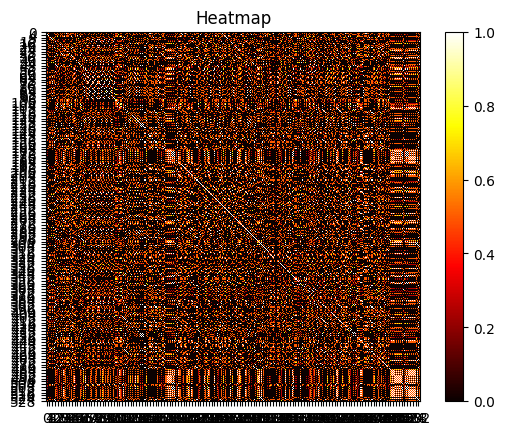

In [15]:
import importlib
importlib.reload(cp)
cp.mat_heatmap(m)

529 x 535
[[ 0.5  0.   0.  ...  1.   0.   0. ]
 [ 0.   0.5 -0.  ... -0.   2.   0.5]
 [ 0.  -0.   1.  ...  0.5  0.5  3. ]
 ...
 [ 0.5 -0.   0.5 ... 94.  95.  97. ]
 [ 0.   0.5 -0.  ... 92.5 95.  95.5]
 [ 0.  -0.   1.  ... 91.  93.  95. ]]
Maximum path sum: 95.0
Accuracy:  0.17958412098298676
Path: [(0, 12), (1, 13), (2, 14), (3, 15), (4, 16), (5, 17), (6, 18), (7, 19), (8, 20), (9, 21), (10, 22), (11, 23), (12, 24), (13, 25), (14, 26), (15, 27), (16, 28), (17, 29), (18, 30), (19, 31), (20, 32), (21, 33), (22, 34), (23, 35), (24, 36), (25, 37), (26, 38), (27, 39), (28, 40), (29, 41), (30, 42), (31, 43), (32, 44), (33, 45), (34, 46), (35, 47), (36, 48), (37, 49), (38, 50), (39, 51), (40, 52), (41, 53), (42, 54), (43, 55), (44, 56), (45, 57), (46, 58), (47, 59), (48, 60), (49, 61), (50, 62), (51, 63), (52, 64), (53, 65), (54, 66), (55, 67), (56, 68), (57, 69), (58, 70), (59, 71), (60, 72), (61, 73), (62, 74), (63, 75), (64, 76), (65, 77), (66, 78), (67, 79), (68, 80), (69, 81), (70, 82), (

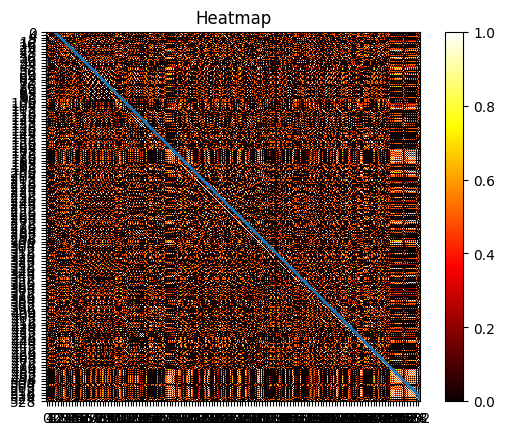

In [17]:
cp.mat_heatmap(m, cp.find_opt(m)[1])

---

In [8]:
def prt_prob(rdict):
    def text_to_romaji(lyrics):
        katsu = cutlet.Cutlet(use_foreign_spelling=False); l = []
        for phrase in lyrics:
            l.append(katsu.romaji(phrase['text'], capitalize=False))
        return l
    
    romaji_list = text_to_romaji(rdict['segments'])
    for idx, seg in enumerate(rdict['segments']):
        for word in seg['words']:
            p = int(255*float(word['probability']))
            print(rgbtxt((0,0,0),(255,p,p),word['word']), end='')
        print()
        print(romaji_list[idx])

あのね 私 実は傷ついてるんだけど
ano ne watakushi jitsu wa kizutsuiteru n dakedo






ほら君が言ったこと
horakun ga itta koto
甘い
amai
考えたいと思えなくて
kangaetai to omoenakute
忘れてたんだけど
wasureteta n dakedo
盲目的に 妄想的に 妄想的に 生きて
moumokuteki ni mousouteki ni mousouteki ni ikite
衝動的な 焦燥的な 消極的なままじゃ ダメだったんだ
shoudouteki na shousouteki na shoukyokuteki na mama ja dame datta n da
きっと
kitto
人生最高の日を前に思うのだろう
jinsei saikou no hi wo mae ni omou no darou
全部全部痛いのですけど
zenbu zenbu itai no desukedo
ああ、いつか
aa, itsu ka
人生最高の日
jinsei saikou no hi
君がいないことを
kimi ga inai koto wo
もっともっともっと
motto motto motto
もっとちゃんと言って
motto chanto itte
【歌】
[uta]
あのね
ano ne
空が青いのってどうやって
sora ga aoi no tte dou yatte
伝えればいいんだろうね
tsutaereba ii n darou ne
夜の 雲が 高いのってどうすれば
yoru no kumo ga takai no tte dou sureba
君もわかるんだろう 言って
kimi mo wakaru n darou itte
あのね 私 実は分かってるの もう君が言ったこと
ano ne watakushi jitsu wa wakatteru no mou kimi ga itta koto
あのね わからずやって言うんだろうね 忘れたいんだけど
ano ne wakarazu yatte iu n darou ne wasuretai n dakedo
もっとちゃんと言ってよ 忘れないよメモにしてよ
motto chanto itte yo wa